In [133]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression,
    LassoCV,
    RidgeCV,
    Lasso,
    Ridge,
    ElasticNet,
)
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

In [134]:
sns.set_style("darkgrid")
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["figure.figsize"] = (10, 6)
matplotlib.rcParams["figure.facecolor"] = "#00000000"

In [135]:
medical_df = pd.read_csv("medical.csv")

medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [136]:
cat_col = medical_df.select_dtypes(include=["object"]).columns

num_col = medical_df.select_dtypes(
    include=["int64", "float64"]).columns.to_list()

num_col.remove("charges")

print(num_col, cat_col)

['age', 'bmi', 'children'] Index(['sex', 'smoker', 'region'], dtype='object')


In [137]:
sc = StandardScaler()
sc.fit(medical_df[num_col])

medical_df[num_col] = sc.transform(medical_df[num_col])

medical_df = pd.get_dummies(medical_df, columns=cat_col, drop_first=True)

medical_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,16884.92400,0,1,0,0,1
1,-1.509965,0.509621,-0.078767,1725.55230,1,0,0,1,0
2,-0.797954,0.383307,1.580926,4449.46200,1,0,0,1,0
3,-0.441948,-1.305531,-0.908614,21984.47061,1,0,1,0,0
4,-0.513149,-0.292556,-0.908614,3866.85520,1,0,1,0,0


In [138]:
X, y = medical_df.drop("charges", axis=1), medical_df["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

X_train.shape, X_test.shape

((669, 8), (669, 8))

In [139]:
X_train.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [140]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test))

0.7217021392151597 0.7741831666132295


## Forward Feature Selection

Text(0.5, 1.0, 'Correlation Matrix')

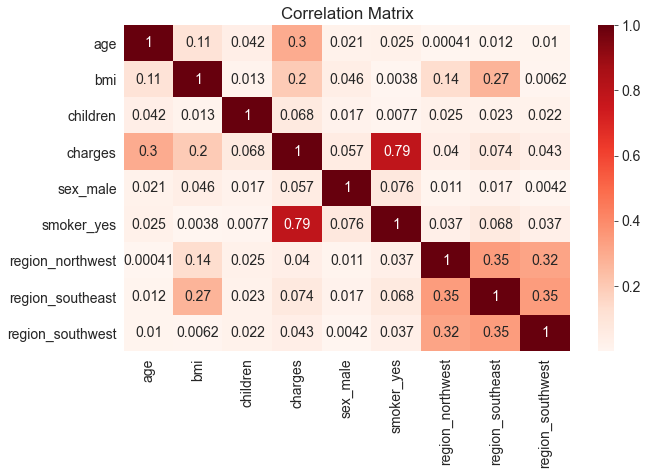

In [141]:
sns.heatmap(np.abs(medical_df.corr()), cmap="Reds", annot=True)
plt.title("Correlation Matrix")

In [142]:
for i, col in enumerate(X_train.columns):
    lr = LinearRegression()
    lr.fit(X_train[[col]], y_train)
    print(f"{col}: {lr.score(X_test[[col]], y_test)}")

age: 0.09146248376294519
bmi: 0.04297845800125477
children: -0.0003675526514141936
sex_male: -0.0001179767548995514
smoker_yes: 0.644798769809819
region_northwest: -0.001621287913223135
region_southeast: 0.0031571849549758557
region_southwest: -0.0023716960925159736


In [143]:
new_list = X_train.columns.to_list()
new_list.remove("smoker_yes")

for i, col in enumerate(new_list):
    lr = LinearRegression()
    new_col = ["smoker_yes"] + [col]
    lr.fit(X_train[new_col], y_train)
    print(f"{col}: {lr.score(X_test[new_col], y_test)}")

age: 0.7458202190656231
bmi: 0.6848052219590511
children: 0.6482136565708957
sex_male: 0.6447650597347621
region_northwest: 0.6443266983920574


region_southeast: 0.6446934706313998
region_southwest: 0.6447204100489599


In [144]:
new_list.remove("age")

for i, col in enumerate(new_list):
    lr = LinearRegression()
    new_col = ["smoker_yes", "age"] + [col]
    lr.fit(X_train[new_col], y_train)
    print(f"{col}: {lr.score(X_test[new_col], y_test)}")

bmi: 0.7722465285500775
children: 0.7482016426711827
sex_male: 0.7458409784927225
region_northwest: 0.7457213517953296
region_southeast: 0.745801649180825
region_southwest: 0.7456165938432273


In [145]:
new_list.remove("bmi")

for i, col in enumerate(new_list):
    lr = LinearRegression()
    new_col = ["smoker_yes", "age", "bmi"] + [col]
    lr.fit(X_train[new_col], y_train)
    print(f"{col}: {lr.score(X_test[new_col], y_test)}")

children: 0.7745059360753903
sex_male: 0.7720113969065017
region_northwest: 0.772384078539925
region_southeast: 0.7727234237660503
region_southwest: 0.7711693392104209


In [146]:
new_list.remove("children")

for i, col in enumerate(new_list):
    lr = LinearRegression()
    new_col = ["smoker_yes", "age", "bmi", "children"] + [col]
    lr.fit(X_train[new_col], y_train)
    print(f"{col}: {lr.score(X_test[new_col], y_test)}")

sex_male: 0.7743192603476412
region_northwest: 0.7745961290407464
region_southeast: 0.7749353299982344
region_southwest: 0.7735966274770578


In [147]:
lr = LinearRegression()
new_col = ["smoker_yes", "age", "bmi", "children"]
lr.fit(X_train[new_col], y_train)
print(f"train score: {lr.score(X_train[new_col], y_train)}")
print(f"test score: {lr.score(X_test[new_col], y_test)}")

train score: 0.7197003299633349
test score: 0.7745059360753903


In [160]:
cv = KFold(n_splits=3, random_state=1, shuffle=True)

las = LassoCV(alphas=np.geomspace(1, 20, 30), cv=cv)

las.fit(X_train[new_col], y_train)

print(f"train score: {las.score(X_train[new_col], y_train)}")
print(f"test score: {las.score(X_test[new_col], y_test)}")

train score: 0.7196728312770043
test score: 0.7740766641002647


In [158]:
las.alpha_

7.1186716694711665

In [161]:
rig = RidgeCV(alphas=np.geomspace(1, 20, 30), cv=cv)

rig.fit(X_train[new_col], y_train)

print(f"train score: {rig.score(X_train[new_col], y_train)}")
print(f"test score: {rig.score(X_test[new_col], y_test)}")

train score: 0.7195068170630554
test score: 0.7733627299396428


In [159]:
rig.alpha_

1.6761601701448399

In [128]:
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(X_train[new_col])
X_reduced.shape

(1070, 4)

In [129]:
lr = LinearRegression()
new_col = ["smoker_yes", "age", "bmi", "children"]
lr.fit(X_reduced, y_train)
print(f"train score: {lr.score(X_reduced, y_train)}")
# print(f"test score: {lr.score(X_test[new_col], y_test)}")

train score: 0.7410887501824264


## Model Interpretation

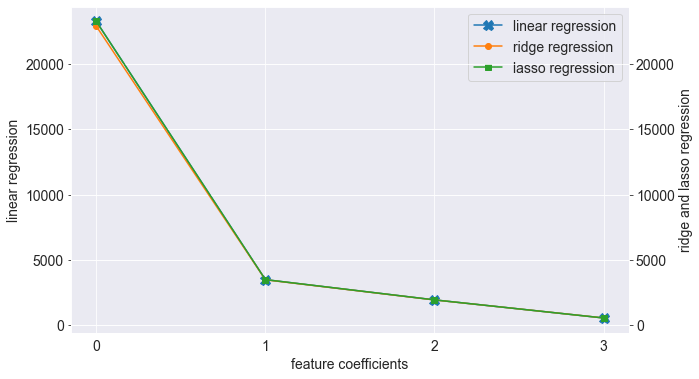

In [152]:
from matplotlib import markers


colors = sns.color_palette()

# Setup the dual y-axes
ax1 = plt.axes()
ax2 = ax1.twinx()

# Plot the linear regression data
ax1.plot(
    lr.coef_.ravel(),
    color=colors[0],
    marker="X",
    label="linear regression",
    markersize=10,
)

# Plot the regularization data sets
ax2.plot(rig.coef_.ravel(), color=colors[1], marker="o", label="ridge regression")

ax2.plot(las.coef_.ravel(), color=colors[2], marker="s", label="lasso regression")

# Customize axes scales
# ax1.set_ylim(-2e14, 2e14)
# ax2.set_ylim(-25, 25)

# Combine the legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2)

ax1.set(xlabel="feature coefficients", ylabel="linear regression")
ax2.set(ylabel="ridge and lasso regression")

ax1.set_xticks(range(len(lr.coef_)))

plt.show()

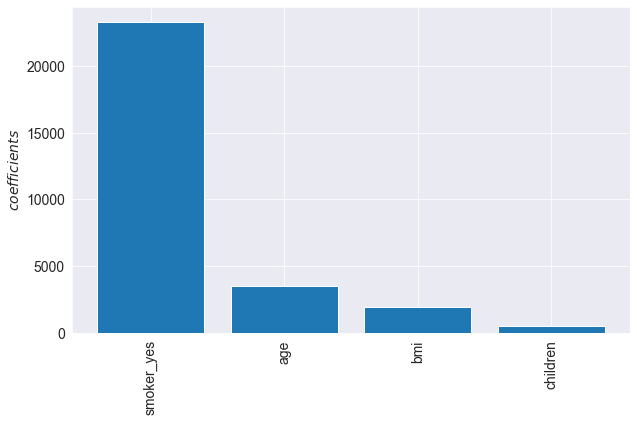

In [153]:
plt.bar(new_col, abs(lr.coef_))
plt.xticks(rotation=90)
plt.ylabel("$coefficients$")
plt.show()

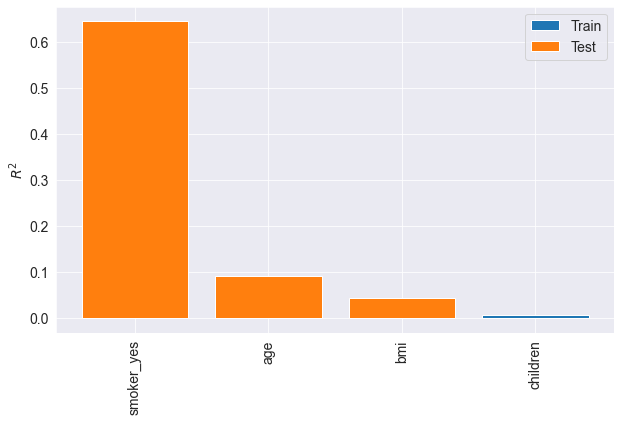

Training R^2 mean value 0.1767227458733112 Testing R^2 mean value 0.1947180397306512 
Training R^2 max value 0.588665715555589 Testing R^2 max value 0.644798769809819 


In [154]:
def get_R2_features(model, test=True):
    # X: global
    features = new_col

    R_2_train = []
    R_2_test = []

    for feature in features:
        model.fit(X_train[[feature]], y_train)

        R_2_test.append(model.score(X_test[[feature]], y_test))
        R_2_train.append(model.score(X_train[[feature]], y_train))

    plt.bar(features, R_2_train, label="Train")
    plt.bar(features, R_2_test, label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print(
        "Training R^2 mean value {} Testing R^2 mean value {} ".format(
            str(np.mean(R_2_train)), str(np.mean(R_2_test))
        )
    )
    print(
        "Training R^2 max value {} Testing R^2 max value {} ".format(
            str(np.max(R_2_train)), str(np.max(R_2_test))
        )
    )


get_R2_features(LinearRegression())